In [1]:
import meep as mp
import numpy as np
import matplotlib.pyplot as plt
from typing import Tuple
from scipy.optimize import minimize

#Au material script from complex refractive index data

wvl_data = np.array([250.000000, 260.000000, 270.000000, 280.000000, 290.000000, 300.000000,
                              310.000000, 320.000000, 330.000000, 340.000000, 350.000000, 360.000000,
                              370.000000, 380.000000, 390.000000, 400.000000, 410.000000, 420.000000,
                              430.000000, 440.000000, 450.000000, 460.000000, 470.000000, 480.000000,
                              490.000000, 500.000000, 510.000000, 520.000000, 530.000000, 540.000000,
                              550.000000, 560.000000, 570.000000, 580.000000, 590.000000, 600.000000,
                              610.000000, 620.000000, 630.000000, 640.000000, 650.000000, 660.000000,
                              670.000000, 680.000000, 690.000000, 700.000000, 710.000000, 720.000000,
                              730.000000, 740.000000, 750.000000, 760.000000, 770.000000, 780.000000,
                              790.000000, 800.000000, 810.000000, 820.000000, 830.000000, 840.000000,
                              850.000000, 860.000000, 870.000000, 880.000000, 890.000000, 900.000000,
                              910.000000, 920.000000, 930.000000, 940.000000, 950.000000, 960.000000,
                              970.000000, 980.000000, 990.000000, 1000.000000])

#Refractive index data
n_data = np.array([1.486293, 1.517101, 1.602219, 1.678100, 1.750429, 1.800042, 1.830000, 1.836011,
                   1.813111, 1.781199, 1.751161, 1.726732, 1.706249, 1.687926, 1.670782, 1.658000,
                   1.641467, 1.626593, 1.607286, 1.572004, 1.503407, 1.417996, 1.315496, 1.189871,
                   1.018554, 0.849238, 0.698231, 0.571152, 0.475555, 0.397920, 0.355713, 0.318417,
                   0.295010, 0.278152, 0.261664, 0.245531, 0.229740, 0.214278, 0.199131, 0.184288,
                   0.169737, 0.164060, 0.162125, 0.160792, 0.160087, 0.160906, 0.161863, 0.162930,
                   0.164154, 0.166357, 0.168557, 0.170750, 0.172934, 0.175425, 0.178189, 0.180917,
                   0.183609, 0.186265, 0.189334, 0.193206, 0.197006, 0.200737, 0.204403, 0.208008,
                   0.211773, 0.215750, 0.219658, 0.223500, 0.227279, 0.230997, 0.234659, 0.239028,
                   0.243770, 0.248435, 0.253026, 0.257546])

#Absorption coefficient data (imaginary coefficient of complex refractive index)
k_data = np.array([1.660980, 1.759202, 1.824512, 1.873471, 1.904443, 1.919298, 1.916000, 1.897531,
                   1.870450, 1.852625, 1.847116, 1.855697, 1.883198, 1.916907, 1.939990, 1.956000,
                   1.957488, 1.949527, 1.934151, 1.910625, 1.878436, 1.843614, 1.814717, 1.799925,
                   1.820950, 1.892178, 2.027084, 2.185897, 2.374957, 2.553141, 2.695668, 2.832206,
                   2.899935, 2.930925, 2.961718, 2.992315, 3.022714, 3.052916, 3.082919, 3.112725,
                   3.142334, 3.293285, 3.477580, 3.652616, 3.817434, 3.959739, 4.097111, 4.230027,
                   4.358280, 4.474892, 4.588542, 4.699445, 4.807792, 4.914824, 5.020584, 5.124162,
                   5.225688, 5.325278, 5.419440, 5.505117, 5.589481, 5.672590, 5.754499, 5.835259,
                   5.919898, 6.009588, 6.097960, 6.185070, 6.270970, 6.355709, 6.439333, 6.519685,
                   6.597783, 6.674968, 6.751271, 6.826722])


#Fit the data to Lorentz Function and generate Au material

def lorentzfunc(p: np.ndarray, x: np.ndarray) -> np.ndarray:
    """
    Returns the complex ε profile given a set of Lorentzian parameters p
    (σ_0, ω_0, γ_0, σ_1, ω_1, γ_1, ...) for a set of frequencies x.
    """
    N = len(p) // 3
    y = np.zeros(len(x))
    for n in range(N):
        A_n, x_n, g_n = p[3 * n : 3 * n + 3]
        y = y + A_n / (np.square(x_n) - np.square(x) - 1j * x * g_n)
    return y


def lorentzerr(p: np.ndarray, x: np.ndarray, y: np.ndarray) -> float:
    """
    Returns the error (or residual or loss) as the L2 norm
    of the difference of ε(p,x) and y over a set of frequencies x.
    """
    yp = lorentzfunc(p, x)
    val = np.sum(np.square(abs(y - yp)))
    return val


def lorentzfit(
    p0: np.ndarray,
    x: np.ndarray,
    y: np.ndarray,
    tol: float = 1e-25,
    maxeval: float = 10000,
) -> Tuple[np.ndarray, float]:
    """
    Returns the optimal Lorentzian polarizability parameters and error
    which minimize the error in ε(p0,x) relative to y for an initial
    set of Lorentzian polarizability parameters p0 over a set of
    frequencies x using the scipy.optimize algorithm for a relative
    tolerance tol and a maximum number of iterations maxeval.
    """
    result = minimize(
        lambda p: lorentzerr(p, x, y),
        p0,
        method="L-BFGS-B",
        options={"ftol": tol, "maxiter": maxeval},
    )
    popt = result.x
    minf = result.fun
    return popt, minf


if __name__ == "__main__":
    
    n = n_data[:] + 1j * k_data[:]
    eps_inf = 1.1

    eps = np.square(n) - eps_inf

    wl = wvl_data[:]
    wl_min = 250  # minimum wavelength (units of nm)
    wl_max = 1000  # maximum wavelength (units of nm)
    start_idx = np.where(wl > wl_min)
    idx_start = start_idx[0][0]
    end_idx = np.where(wl < wl_max)
    idx_end = end_idx[0][-1] + 1

    # The fitting function is ε(f) where f is the frequency, rather than ε(λ).
    freqs = 1000 / wl  # units of 1/μm
    freqs_reduced = freqs[idx_start:idx_end]
    wl_reduced = wl[idx_start:idx_end]
    eps_reduced = eps[idx_start:idx_end]

    # Fitting parameter: number of Lorentzian terms to use in the fit
    num_lorentzians = 2

    # Number of times to repeat local optimization with random initial values.
    num_repeat = 30

    ps = np.zeros((num_repeat, 3 * num_lorentzians))
    mins = np.zeros(num_repeat)
    for m in range(num_repeat):
        # Initial values for the Lorentzian polarizability terms. Each term
        # consists of three parameters (σ, ω, γ) and is chosen randomly.
        # Note: for the case of no absorption, γ should be set to zero.
        p_rand = [10 ** (np.random.random()) for _ in range(3 * num_lorentzians)]
        ps[m, :], mins[m] = lorentzfit(p_rand, freqs_reduced, eps_reduced, 1e-25, 50000)
        ps_str = "( " + ", ".join(f"{prm:.4f}" for prm in ps[m, :]) + " )"
        print(f"iteration:, {m:3d}, ps_str, {mins[m]:.6f}")

    # Find the best performing set of parameters.
    idx_opt = np.argmin(mins)
    popt_str = "( " + ", ".join(f"{prm:.4f}" for prm in ps[idx_opt]) + " )"
    print(f"optimal:, {popt_str}, {mins[idx_opt]:.6f}")

    # Define a `Medium` class object using the optimal fitting parameters.
    E_susceptibilities = []

    for n in range(num_lorentzians):
        mymaterial_freq, mymaterial_gamma = ps[idx_opt][3 * n + 1:3 * n + 3]

        if mymaterial_freq == 0:
            mymaterial_sigma = ps[idx_opt][3 * n + 0]
            E_susceptibilities.append(
                mp.DrudeSusceptibility(
                    frequency=1.0, gamma=mymaterial_gamma, sigma=mymaterial_sigma
                )
            )
        else:
            mymaterial_sigma = ps[idx_opt][3 * n + 0] / mymaterial_freq**2
            E_susceptibilities.append(
                mp.LorentzianSusceptibility(
                    frequency=mymaterial_freq,
                    gamma=mymaterial_gamma,
                    sigma=mymaterial_sigma,
                )
            )

    Au = mp.Medium(epsilon=eps_inf, E_susceptibilities=E_susceptibilities)
    

iteration:,   0, ps_str, 13046.013875
iteration:,   1, ps_str, 13045.276770
iteration:,   2, ps_str, 13042.140893
iteration:,   3, ps_str, 148.081582
iteration:,   4, ps_str, 148.081582
iteration:,   5, ps_str, 13047.349375
iteration:,   6, ps_str, 148.081582
iteration:,   7, ps_str, 13042.480342
iteration:,   8, ps_str, 148.081582
iteration:,   9, ps_str, 13043.061880
iteration:,  10, ps_str, 13047.520874
iteration:,  11, ps_str, 13045.950745
iteration:,  12, ps_str, 148.081582
iteration:,  13, ps_str, 13048.872819
iteration:,  14, ps_str, 148.081582
iteration:,  15, ps_str, 13040.036651
iteration:,  16, ps_str, 300.869979
iteration:,  17, ps_str, 148.081582
iteration:,  18, ps_str, 13051.849614
iteration:,  19, ps_str, 1282.001598
iteration:,  20, ps_str, 148.081582
iteration:,  21, ps_str, 13046.736443
iteration:,  22, ps_str, 13041.921631
iteration:,  23, ps_str, 148.081582
iteration:,  24, ps_str, 13039.763626
iteration:,  25, ps_str, 298.846637
iteration:,  26, ps_str, 13046.3632

In [2]:
#Nanorod scattering spectrum
#AR Constant

import meep as mp
import numpy as np
import matplotlib.pyplot as plt


def get_spectrum_nanorod(fraction, wvl_min, wvl_max):

    r = 7.25E-3  # radius of cylinder
    l = 25.40E-3 # length of rod
    
    frac = fraction
    l_c = frac*l # length of cylinder
    
    l_e = 0.5*(l-l_c) # length of half ellipsoid
    
    #default medium is water
    default_material = mp.Medium(index=1.3325)
    
    frq_min = 1 / wvl_max
    frq_max = 1 / wvl_min
    frq_cen = 0.5 * (frq_min + frq_max)
    dfrq = frq_max - frq_min
    nfrq = 100
    
    resolution = 32/r
    
    dpml = 2*r
    pml_layers = [mp.PML(thickness=dpml)]
    
    #symmetries = [mp.Mirror(mp.Y)]
    
    s = 3*l + dpml
    cell_size = mp.Vector3(s, s)
    
    # is_integrated=True necessary for any planewave source extending into PML
    sources = [
        mp.Source(
            mp.GaussianSource(frq_cen, fwidth=dfrq, is_integrated=True),
            center=mp.Vector3(-0.5*s + dpml),
            size=mp.Vector3(0, s),
            component=mp.Hz,
        )
    ]
    
    
    sim = mp.Simulation(
        resolution=resolution,
        cell_size=cell_size,
        boundary_layers=pml_layers,
        default_material = default_material,
        sources=sources,
        k_point=mp.Vector3()
    )
    
    
    
    box_x1 = sim.add_flux(
        frq_cen,
        dfrq,
        nfrq,
        mp.FluxRegion(center=mp.Vector3(x=-0.5*l), size=mp.Vector3(0, l)),
    )
    
    box_x2 = sim.add_flux(
        frq_cen,
        dfrq,
        nfrq,
        mp.FluxRegion(center=mp.Vector3(x=+0.5*l), size=mp.Vector3(0, l)),
    )
    
    box_y1 = sim.add_flux(
        frq_cen,
        dfrq,
        nfrq,
        mp.FluxRegion(center=mp.Vector3(y= -0.5*l), size=mp.Vector3(l, 0)),
    )
    
    box_y2 = sim.add_flux(
        frq_cen,
        dfrq,
        nfrq,
        mp.FluxRegion(center=mp.Vector3(y= 0.5*l), size=mp.Vector3(l, 0)),
    )

    sim.run(until_after_sources=10)
    
    freqs = mp.get_flux_freqs(box_x1)
    box_x1_data = sim.get_flux_data(box_x1)
    box_x2_data = sim.get_flux_data(box_x2)
    box_y1_data = sim.get_flux_data(box_y1)
    box_y2_data = sim.get_flux_data(box_y2)
    
    box_x1_flux0 = mp.get_fluxes(box_x1)
    
    sim.reset_meep()



    

    ellip_1 = mp.Ellipsoid(material=Au,
                           size = mp.Vector3(2*r, 2*l_e),
                           center=mp.Vector3(0, 0.5*l_c))
    
    ellip_2 = mp.Ellipsoid(material=Au,
                           size = mp.Vector3(2*r, 2*l_e),
                           center=mp.Vector3(0, -0.5*l_c))
    
    #axis says the orentation of the cylinder
    cylinder = mp.Cylinder(material=Au,
                           radius=r,
                           height=l_c,
                           center=mp.Vector3(),
                           axis=mp.Vector3(0, 1))
    
    geometry = [ellip_1, ellip_2, cylinder]
    
    sim = mp.Simulation(
        resolution=resolution,
        cell_size=cell_size,
        boundary_layers=pml_layers,
        default_material = default_material,
        sources=sources,
        k_point=mp.Vector3(),
        geometry=geometry,
    )
    
    
    
    box_x1 = sim.add_flux(
        frq_cen,
        dfrq,
        nfrq,
        mp.FluxRegion(center=mp.Vector3(x=-0.5*l), size=mp.Vector3(0, l)),
    )
    
    box_x2 = sim.add_flux(
        frq_cen,
        dfrq,
        nfrq,
        mp.FluxRegion(center=mp.Vector3(x=+0.5*l), size=mp.Vector3(0, l)),
    )
    
    box_y1 = sim.add_flux(
        frq_cen,
        dfrq,
        nfrq,
        mp.FluxRegion(center=mp.Vector3(y= -0.5*l), size=mp.Vector3(l, 0)),
    )
    
    box_y2 = sim.add_flux(
        frq_cen,
        dfrq,
        nfrq,
        mp.FluxRegion(center=mp.Vector3(y= 0.5*l), size=mp.Vector3(l, 0)),
    )
    
    
    
    sim.load_minus_flux_data(box_x1, box_x1_data)
    sim.load_minus_flux_data(box_x2, box_x2_data)
    sim.load_minus_flux_data(box_y1, box_y1_data)
    sim.load_minus_flux_data(box_y2, box_y2_data)
    
    sim.run(until_after_sources=100)
    
    #flux power through each flux region.
    box_x1_flux = mp.get_fluxes(box_x1)
    box_x2_flux = mp.get_fluxes(box_x2)
    box_y1_flux = mp.get_fluxes(box_y1)
    box_y2_flux = mp.get_fluxes(box_y2)
    
    
    #Just want to plot the power of the scattered flux against wavelength
    scatt_flux = (
        np.asarray(box_x1_flux)
        - np.asarray(box_x2_flux)
        + np.asarray(box_y1_flux)
        - np.asarray(box_y2_flux)
    )

    perc = str(frac*100)
    
    return scatt_flux, freqs, perc
    #return the scattered flux power data and the range of frequencies



In [3]:
wvl_min = 400E-3
wvl_max = 1000E-3

freq_data = []  #Going to append all raw sim data arrays, to process and plot after the runs
scatt_data = []
percentages = []

fractions = np.linspace(1,0,20)

index = 1

for fraction in fractions:
    print(f"##################### Run {index} Starting #######################")
    scatt_flux, freqs, perc = get_spectrum_nanorod(fraction, wvl_min, wvl_max)
    scatt_data.append(scatt_flux)     #this appends the array as a row.
    freq_data.append(freqs)
    percentages = np.append(percentages, perc)

    index+=1


##################### Run 1 Starting #######################
-----------
Initializing structure...
time for choose_chunkdivision = 0.000553846 s
Working in 2D dimensions.
Computational cell is 0.090625 x 0.090625 x 0 with resolution 4413.79
time for set_epsilon = 0.174749 s
-----------
Meep progress: 0.27334765625000007/16.666666507720947 = 1.6% done in 4.0s, 239.9s to go
on time step 2413 (time=0.273348), 0.00165788 s/step
Meep progress: 0.5802265625000002/16.666666507720947 = 3.5% done in 8.0s, 221.8s to go
on time step 5123 (time=0.58034), 0.00147649 s/step
Meep progress: 0.8918632812500001/16.666666507720947 = 5.4% done in 12.0s, 212.3s to go
on time step 7875 (time=0.89209), 0.00145412 s/step
Meep progress: 1.1887734375000003/16.666666507720947 = 7.1% done in 16.0s, 208.3s to go
on time step 10498 (time=1.18923), 0.0015258 s/step
Meep progress: 1.4961054687500002/16.666666507720947 = 9.0% done in 20.0s, 202.8s to go
on time step 13211 (time=1.49656), 0.001475 s/step
Meep progress:

run 0 finished at t = 16.666730468750004 (147127 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000335932 s
Working in 2D dimensions.
Computational cell is 0.090625 x 0.090625 x 0 with resolution 4413.79
     ellipsoid, center = (0,0.0127,0)
          size (0.0145,0,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.1,1.1,1.1)
     ellipsoid, center = (0,-0.0127,0)
          size (0.0145,0,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.1,1.1,1.1)
     cylinder, center = (0,0,0)
          radius 0.00725, height 0.0254, axis (0, 1, 0)
          dielectric constant epsilon diagonal = (1.1,1.1,1.1)
time for set_epsilon = 0.18443 s
lorentzian susceptibility: frequency=-0.524219, gamma=0.0182963
lorentzian susceptibility: frequency=3.65545, gamma=2.74085
-----------
Meep progress: 0.14205468750000003/106.66666650772095 = 0.1% done in 4.0s, 3000.3s to go
on time st

run 0 finished at t = 106.66675781250002 (941610 timesteps)
##################### Run 2 Starting #######################
-----------
Initializing structure...
time for choose_chunkdivision = 0.000693083 s
Working in 2D dimensions.
Computational cell is 0.090625 x 0.090625 x 0 with resolution 4413.79
time for set_epsilon = 0.277593 s
-----------
Meep progress: 0.24887890625000003/16.666666507720947 = 1.5% done in 4.0s, 263.9s to go
on time step 2197 (time=0.248879), 0.00182078 s/step
Meep progress: 0.5011562500000001/16.666666507720947 = 3.0% done in 8.0s, 258.1s to go
on time step 4425 (time=0.50127), 0.00179611 s/step
Meep progress: 0.7621562500000001/16.666666507720947 = 4.6% done in 12.0s, 250.4s to go
on time step 6730 (time=0.762383), 0.00173809 s/step
Meep progress: 1.0130742187500001/16.666666507720947 = 6.1% done in 16.0s, 247.2s to go
on time step 8948 (time=1.01364), 0.00180378 s/step
Meep progress: 1.2455273437500003/16.666666507720947 = 7.5% done in 20.0s, 247.6s to go
on t

run 0 finished at t = 16.666730468750004 (147127 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000458956 s
Working in 2D dimensions.
Computational cell is 0.090625 x 0.090625 x 0 with resolution 4413.79
     ellipsoid, center = (0,0.0120316,0)
          size (0.0145,0.00133684,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.1,1.1,1.1)
     ellipsoid, center = (0,-0.0120316,0)
          size (0.0145,0.00133684,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.1,1.1,1.1)
     cylinder, center = (0,0,0)
          radius 0.00725, height 0.0240632, axis (0, 1, 0)
          dielectric constant epsilon diagonal = (1.1,1.1,1.1)
time for set_epsilon = 0.278669 s
lorentzian susceptibility: frequency=-0.524219, gamma=0.0182963
lorentzian susceptibility: frequency=3.65545, gamma=2.74085
-----------
Meep progress: 0.13174609375000002/106.66666650772095 = 0.1% done in 4.

Meep progress: 106.66109375000002/106.66666650772095 = 100.0% done in 3341.7s, 0.2s to go
run 0 finished at t = 106.66675781250002 (941610 timesteps)
##################### Run 3 Starting #######################
-----------
Initializing structure...
time for choose_chunkdivision = 0.00102687 s
Working in 2D dimensions.
Computational cell is 0.090625 x 0.090625 x 0 with resolution 4413.79
time for set_epsilon = 0.238325 s
-----------
Meep progress: 0.21342187500000004/16.666666507720947 = 1.3% done in 4.0s, 308.5s to go
on time step 1884 (time=0.213422), 0.00212409 s/step
Meep progress: 0.4900546875000001/16.666666507720947 = 2.9% done in 8.0s, 264.2s to go
on time step 4327 (time=0.490168), 0.00163776 s/step
Meep progress: 0.7722382812500002/16.666666507720947 = 4.6% done in 12.0s, 247.0s to go
on time step 6819 (time=0.772465), 0.00160559 s/step
Meep progress: 1.0407148437500002/16.666666507720947 = 6.2% done in 16.0s, 240.3s to go
on time step 9190 (time=1.04105), 0.00168743 s/step
Me

run 0 finished at t = 16.666730468750004 (147127 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000912905 s
Working in 2D dimensions.
Computational cell is 0.090625 x 0.090625 x 0 with resolution 4413.79
     ellipsoid, center = (0,0.0113632,0)
          size (0.0145,0.00267368,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.1,1.1,1.1)
     ellipsoid, center = (0,-0.0113632,0)
          size (0.0145,0.00267368,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.1,1.1,1.1)
     cylinder, center = (0,0,0)
          radius 0.00725, height 0.0227263, axis (0, 1, 0)
          dielectric constant epsilon diagonal = (1.1,1.1,1.1)
time for set_epsilon = 0.271928 s
lorentzian susceptibility: frequency=-0.524219, gamma=0.0182963
lorentzian susceptibility: frequency=3.65545, gamma=2.74085
-----------
Meep progress: 0.12223046875000002/106.66666650772095 = 0.1% done in 4.

run 0 finished at t = 106.66675781250002 (941610 timesteps)
##################### Run 4 Starting #######################
-----------
Initializing structure...
time for choose_chunkdivision = 0.000592232 s
Working in 2D dimensions.
Computational cell is 0.090625 x 0.090625 x 0 with resolution 4413.79
time for set_epsilon = 0.224544 s
-----------
Meep progress: 0.36329296875000006/16.666666507720947 = 2.2% done in 4.0s, 179.5s to go
on time step 3207 (time=0.363293), 0.00124735 s/step
Meep progress: 0.7955742187500001/16.666666507720947 = 4.8% done in 8.0s, 159.6s to go
on time step 7024 (time=0.795688), 0.00104827 s/step
Meep progress: 1.2923125000000002/16.666666507720947 = 7.8% done in 12.0s, 142.8s to go
on time step 11410 (time=1.29254), 0.000912076 s/step
Meep progress: 1.7440781250000004/16.666666507720947 = 10.5% done in 16.0s, 136.9s to go
on time step 15398 (time=1.7443), 0.00100305 s/step
Meep progress: 2.2445546875000004/16.666666507720947 = 13.5% done in 20.0s, 128.5s to go


run 0 finished at t = 16.666730468750004 (147127 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000330925 s
Working in 2D dimensions.
Computational cell is 0.090625 x 0.090625 x 0 with resolution 4413.79
     ellipsoid, center = (0,0.0106947,0)
          size (0.0145,0.00401053,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.1,1.1,1.1)
     ellipsoid, center = (0,-0.0106947,0)
          size (0.0145,0.00401053,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.1,1.1,1.1)
     cylinder, center = (0,0,0)
          radius 0.00725, height 0.0213895, axis (0, 1, 0)
          dielectric constant epsilon diagonal = (1.1,1.1,1.1)
time for set_epsilon = 0.145793 s
lorentzian susceptibility: frequency=-0.524219, gamma=0.0182963
lorentzian susceptibility: frequency=3.65545, gamma=2.74085
-----------
Meep progress: 0.19337109375000003/106.66666650772095 = 0.2% done in 4.

run 0 finished at t = 106.66675781250002 (941610 timesteps)
##################### Run 5 Starting #######################
-----------
Initializing structure...
time for choose_chunkdivision = 0.000748158 s
Working in 2D dimensions.
Computational cell is 0.090625 x 0.090625 x 0 with resolution 4413.79
time for set_epsilon = 0.192276 s
-----------
Meep progress: 0.4293359375000001/16.666666507720947 = 2.6% done in 4.0s, 151.3s to go
on time step 3790 (time=0.429336), 0.00105551 s/step
Meep progress: 0.8700000000000001/16.666666507720947 = 5.2% done in 8.0s, 145.3s to go
on time step 7680 (time=0.87), 0.00102828 s/step
Meep progress: 1.3410234375000003/16.666666507720947 = 8.0% done in 12.0s, 137.2s to go
on time step 11839 (time=1.34114), 0.000961948 s/step
Meep progress: 1.8639296875000002/16.666666507720947 = 11.2% done in 16.0s, 127.1s to go
on time step 16456 (time=1.86416), 0.000866464 s/step
Meep progress: 2.3931796875000004/16.666666507720947 = 14.4% done in 20.0s, 119.3s to go
on 

run 0 finished at t = 16.666730468750004 (147127 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000309229 s
Working in 2D dimensions.
Computational cell is 0.090625 x 0.090625 x 0 with resolution 4413.79
     ellipsoid, center = (0,0.0100263,0)
          size (0.0145,0.00534737,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.1,1.1,1.1)
     ellipsoid, center = (0,-0.0100263,0)
          size (0.0145,0.00534737,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.1,1.1,1.1)
     cylinder, center = (0,0,0)
          radius 0.00725, height 0.0200526, axis (0, 1, 0)
          dielectric constant epsilon diagonal = (1.1,1.1,1.1)
time for set_epsilon = 0.14677 s
lorentzian susceptibility: frequency=-0.524219, gamma=0.0182963
lorentzian susceptibility: frequency=3.65545, gamma=2.74085
-----------
Meep progress: 0.19382421875000003/106.66666650772095 = 0.2% done in 4.0

run 0 finished at t = 106.66675781250002 (941610 timesteps)
##################### Run 6 Starting #######################
-----------
Initializing structure...
time for choose_chunkdivision = 0.000784874 s
Working in 2D dimensions.
Computational cell is 0.090625 x 0.090625 x 0 with resolution 4413.79
time for set_epsilon = 0.278039 s
-----------
Meep progress: 0.27232812500000003/16.666666507720947 = 1.6% done in 4.0s, 240.9s to go
on time step 2404 (time=0.272328), 0.00166445 s/step
Meep progress: 0.5877031250000001/16.666666507720947 = 3.5% done in 8.0s, 218.9s to go
on time step 5188 (time=0.587703), 0.00143685 s/step
Meep progress: 0.9525820312500002/16.666666507720947 = 5.7% done in 12.0s, 198.0s to go
on time step 8409 (time=0.952582), 0.00124194 s/step
Meep progress: 1.3218789062500003/16.666666507720947 = 7.9% done in 16.0s, 185.8s to go
on time step 11669 (time=1.32188), 0.00122708 s/step
Meep progress: 1.6861914062500003/16.666666507720947 = 10.1% done in 20.0s, 177.7s to go
o

run 0 finished at t = 16.666730468750004 (147127 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000549793 s
Working in 2D dimensions.
Computational cell is 0.090625 x 0.090625 x 0 with resolution 4413.79
     ellipsoid, center = (0,0.00935789,0)
          size (0.0145,0.00668421,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.1,1.1,1.1)
     ellipsoid, center = (0,-0.00935789,0)
          size (0.0145,0.00668421,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.1,1.1,1.1)
     cylinder, center = (0,0,0)
          radius 0.00725, height 0.0187158, axis (0, 1, 0)
          dielectric constant epsilon diagonal = (1.1,1.1,1.1)
time for set_epsilon = 0.29313 s
lorentzian susceptibility: frequency=-0.524219, gamma=0.0182963
lorentzian susceptibility: frequency=3.65545, gamma=2.74085
-----------
Meep progress: 0.11656640625000002/106.66666650772095 = 0.1% done in 4

run 0 finished at t = 106.66675781250002 (941610 timesteps)
##################### Run 7 Starting #######################
-----------
Initializing structure...
time for choose_chunkdivision = 0.000923157 s
Working in 2D dimensions.
Computational cell is 0.090625 x 0.090625 x 0 with resolution 4413.79
time for set_epsilon = 0.210796 s
-----------
Meep progress: 0.36759765625000007/16.666666507720947 = 2.2% done in 4.0s, 177.4s to go
on time step 3245 (time=0.367598), 0.00123311 s/step
Meep progress: 0.6360742187500001/16.666666507720947 = 3.8% done in 8.0s, 201.7s to go
on time step 5616 (time=0.636188), 0.00168752 s/step
Meep progress: 0.8235546875000002/16.666666507720947 = 4.9% done in 12.0s, 230.9s to go
on time step 7271 (time=0.823668), 0.00241843 s/step
Meep progress: 1.0564609375000003/16.666666507720947 = 6.3% done in 16.0s, 236.5s to go
on time step 9328 (time=1.05669), 0.00194542 s/step
Meep progress: 1.3076054687500003/16.666666507720947 = 7.8% done in 20.0s, 235.0s to go
on 

run 0 finished at t = 16.666730468750004 (147127 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000557899 s
Working in 2D dimensions.
Computational cell is 0.090625 x 0.090625 x 0 with resolution 4413.79
     ellipsoid, center = (0,0.00868947,0)
          size (0.0145,0.00802105,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.1,1.1,1.1)
     ellipsoid, center = (0,-0.00868947,0)
          size (0.0145,0.00802105,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.1,1.1,1.1)
     cylinder, center = (0,0,0)
          radius 0.00725, height 0.0173789, axis (0, 1, 0)
          dielectric constant epsilon diagonal = (1.1,1.1,1.1)
time for set_epsilon = 0.307409 s
lorentzian susceptibility: frequency=-0.524219, gamma=0.0182963
lorentzian susceptibility: frequency=3.65545, gamma=2.74085
-----------
Meep progress: 0.11724609375000002/106.66666650772095 = 0.1% done in 

run 0 finished at t = 106.66675781250002 (941610 timesteps)
##################### Run 8 Starting #######################
-----------
Initializing structure...
time for choose_chunkdivision = 0.000675917 s
Working in 2D dimensions.
Computational cell is 0.090625 x 0.090625 x 0 with resolution 4413.79
time for set_epsilon = 0.177344 s
-----------
Meep progress: 0.41948046875000006/16.666666507720947 = 2.5% done in 4.0s, 154.9s to go
on time step 3703 (time=0.41948), 0.00108039 s/step
Meep progress: 0.8289921875000001/16.666666507720947 = 5.0% done in 8.0s, 152.9s to go
on time step 7319 (time=0.829105), 0.00110648 s/step
Meep progress: 1.2259296875000003/16.666666507720947 = 7.4% done in 12.0s, 151.2s to go
on time step 10823 (time=1.22604), 0.00114158 s/step
Meep progress: 1.6513007812500002/16.666666507720947 = 9.9% done in 16.0s, 145.5s to go
on time step 14578 (time=1.65141), 0.00106532 s/step
Meep progress: 2.07633203125/16.666666507720947 = 12.5% done in 20.0s, 140.6s to go
on time

run 0 finished at t = 16.666730468750004 (147127 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000422955 s
Working in 2D dimensions.
Computational cell is 0.090625 x 0.090625 x 0 with resolution 4413.79
     ellipsoid, center = (0,0.00802105,0)
          size (0.0145,0.00935789,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.1,1.1,1.1)
     ellipsoid, center = (0,-0.00802105,0)
          size (0.0145,0.00935789,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.1,1.1,1.1)
     cylinder, center = (0,0,0)
          radius 0.00725, height 0.0160421, axis (0, 1, 0)
          dielectric constant epsilon diagonal = (1.1,1.1,1.1)
time for set_epsilon = 0.191541 s
lorentzian susceptibility: frequency=-0.524219, gamma=0.0182963
lorentzian susceptibility: frequency=3.65545, gamma=2.74085
-----------
Meep progress: 0.15428906250000002/106.66666650772095 = 0.1% done in 

run 0 finished at t = 106.66675781250002 (941610 timesteps)
##################### Run 9 Starting #######################
-----------
Initializing structure...
time for choose_chunkdivision = 0.000335932 s
Working in 2D dimensions.
Computational cell is 0.090625 x 0.090625 x 0 with resolution 4413.79
time for set_epsilon = 0.177767 s
-----------
Meep progress: 0.40849218750000005/16.666666507720947 = 2.5% done in 4.0s, 159.2s to go
on time step 3606 (time=0.408492), 0.0011096 s/step
Meep progress: 0.8153984375000002/16.666666507720947 = 4.9% done in 8.0s, 155.5s to go
on time step 7199 (time=0.815512), 0.00111353 s/step
Meep progress: 1.2201523437500001/16.666666507720947 = 7.3% done in 12.0s, 151.9s to go
on time step 10773 (time=1.22038), 0.00111949 s/step
Meep progress: 1.6366875000000003/16.666666507720947 = 9.8% done in 16.0s, 147.0s to go
on time step 14451 (time=1.63703), 0.00108768 s/step
Meep progress: 2.05866015625/16.666666507720947 = 12.4% done in 20.0s, 141.9s to go
on time

run 0 finished at t = 16.666730468750004 (147127 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000347137 s
Working in 2D dimensions.
Computational cell is 0.090625 x 0.090625 x 0 with resolution 4413.79
     ellipsoid, center = (0,0.00735263,0)
          size (0.0145,0.0106947,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.1,1.1,1.1)
     ellipsoid, center = (0,-0.00735263,0)
          size (0.0145,0.0106947,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.1,1.1,1.1)
     cylinder, center = (0,0,0)
          radius 0.00725, height 0.0147053, axis (0, 1, 0)
          dielectric constant epsilon diagonal = (1.1,1.1,1.1)
time for set_epsilon = 0.201931 s
lorentzian susceptibility: frequency=-0.524219, gamma=0.0182963
lorentzian susceptibility: frequency=3.65545, gamma=2.74085
-----------
Meep progress: 0.11735937500000002/106.66666650772095 = 0.1% done in 4.

run 0 finished at t = 106.66675781250002 (941610 timesteps)
##################### Run 10 Starting #######################
-----------
Initializing structure...
time for choose_chunkdivision = 0.000319958 s
Working in 2D dimensions.
Computational cell is 0.090625 x 0.090625 x 0 with resolution 4413.79
time for set_epsilon = 0.174778 s
-----------
Meep progress: 0.37122265625000006/16.666666507720947 = 2.2% done in 4.0s, 175.6s to go
on time step 3277 (time=0.371223), 0.00122089 s/step
Meep progress: 0.7833398437500001/16.666666507720947 = 4.7% done in 8.0s, 162.2s to go
on time step 6916 (time=0.783453), 0.00109935 s/step
Meep progress: 1.2006679687500001/16.666666507720947 = 7.2% done in 12.0s, 154.6s to go
on time step 10601 (time=1.20089), 0.00108568 s/step
Meep progress: 1.6195820312500002/16.666666507720947 = 9.7% done in 16.0s, 148.7s to go
on time step 14300 (time=1.61992), 0.00108153 s/step
Meep progress: 2.0381562500000006/16.666666507720947 = 12.2% done in 20.0s, 143.6s to go


run 0 finished at t = 16.666730468750004 (147127 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.00032115 s
Working in 2D dimensions.
Computational cell is 0.090625 x 0.090625 x 0 with resolution 4413.79
     ellipsoid, center = (0,0.00668421,0)
          size (0.0145,0.0120316,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.1,1.1,1.1)
     ellipsoid, center = (0,-0.00668421,0)
          size (0.0145,0.0120316,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.1,1.1,1.1)
     cylinder, center = (0,0,0)
          radius 0.00725, height 0.0133684, axis (0, 1, 0)
          dielectric constant epsilon diagonal = (1.1,1.1,1.1)
time for set_epsilon = 0.200752 s
lorentzian susceptibility: frequency=-0.524219, gamma=0.0182963
lorentzian susceptibility: frequency=3.65545, gamma=2.74085
-----------
Meep progress: 0.15791406250000004/106.66666650772095 = 0.1% done in 4.0

run 0 finished at t = 106.66675781250002 (941610 timesteps)
##################### Run 11 Starting #######################
-----------
Initializing structure...
time for choose_chunkdivision = 0.000475883 s
Working in 2D dimensions.
Computational cell is 0.090625 x 0.090625 x 0 with resolution 4413.79
time for set_epsilon = 0.225022 s
-----------
Meep progress: 0.40566015625000007/16.666666507720947 = 2.4% done in 4.0s, 160.4s to go
on time step 3581 (time=0.40566), 0.00111728 s/step
Meep progress: 0.8055429687500001/16.666666507720947 = 4.8% done in 8.0s, 157.6s to go
on time step 7111 (time=0.805543), 0.00113316 s/step
Meep progress: 1.2070117187500002/16.666666507720947 = 7.2% done in 12.0s, 153.7s to go
on time step 10656 (time=1.20713), 0.00112866 s/step
Meep progress: 1.6008906250000003/16.666666507720947 = 9.6% done in 16.0s, 150.6s to go
on time step 14133 (time=1.601), 0.00115057 s/step
Meep progress: 2.00224609375/16.666666507720947 = 12.0% done in 20.0s, 146.5s to go
on time 

Meep progress: 16.665257812500002/16.666666507720947 = 100.0% done in 2072.2s, 0.2s to go
run 0 finished at t = 16.666730468750004 (147127 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000475168 s
Working in 2D dimensions.
Computational cell is 0.090625 x 0.090625 x 0 with resolution 4413.79
     ellipsoid, center = (0,0.00601579,0)
          size (0.0145,0.0133684,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.1,1.1,1.1)
     ellipsoid, center = (0,-0.00601579,0)
          size (0.0145,0.0133684,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.1,1.1,1.1)
     cylinder, center = (0,0,0)
          radius 0.00725, height 0.0120316, axis (0, 1, 0)
          dielectric constant epsilon diagonal = (1.1,1.1,1.1)
time for set_epsilon = 0.143236 s
lorentzian susceptibility: frequency=-0.524219, gamma=0.0182963
lorentzian susceptibility: frequency=3.65545, gamma=2

run 0 finished at t = 106.66675781250002 (941610 timesteps)
##################### Run 12 Starting #######################
-----------
Initializing structure...
time for choose_chunkdivision = 0.000530958 s
Working in 2D dimensions.
Computational cell is 0.090625 x 0.090625 x 0 with resolution 4413.79
time for set_epsilon = 0.220748 s
-----------
Meep progress: 0.26881640625000003/16.666666507720947 = 1.6% done in 4.0s, 244.1s to go
on time step 2373 (time=0.268816), 0.00168648 s/step
Meep progress: 0.5426171875000001/16.666666507720947 = 3.3% done in 8.0s, 237.8s to go
on time step 4790 (time=0.542617), 0.00165494 s/step
Meep progress: 0.8186835937500001/16.666666507720947 = 4.9% done in 12.0s, 232.4s to go
on time step 7228 (time=0.818797), 0.00164109 s/step
Meep progress: 1.1023398437500003/16.666666507720947 = 6.6% done in 16.0s, 226.0s to go
on time step 9732 (time=1.10245), 0.00159745 s/step
Meep progress: 1.3848632812500001/16.666666507720947 = 8.3% done in 20.0s, 220.8s to go
on

run 0 finished at t = 16.666730468750004 (147127 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000452042 s
Working in 2D dimensions.
Computational cell is 0.090625 x 0.090625 x 0 with resolution 4413.79
     ellipsoid, center = (0,0.00534737,0)
          size (0.0145,0.0147053,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.1,1.1,1.1)
     ellipsoid, center = (0,-0.00534737,0)
          size (0.0145,0.0147053,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.1,1.1,1.1)
     cylinder, center = (0,0,0)
          radius 0.00725, height 0.0106947, axis (0, 1, 0)
          dielectric constant epsilon diagonal = (1.1,1.1,1.1)
time for set_epsilon = 0.299048 s
lorentzian susceptibility: frequency=-0.524219, gamma=0.0182963
lorentzian susceptibility: frequency=3.65545, gamma=2.74085
-----------
Meep progress: 0.11384765625000003/106.66666650772095 = 0.1% done in 4.

run 0 finished at t = 106.66675781250002 (941610 timesteps)
##################### Run 13 Starting #######################
-----------
Initializing structure...
time for choose_chunkdivision = 0.00045085 s
Working in 2D dimensions.
Computational cell is 0.090625 x 0.090625 x 0 with resolution 4413.79
time for set_epsilon = 0.278728 s
-----------
Meep progress: 0.26417187500000006/16.666666507720947 = 1.6% done in 4.0s, 248.4s to go
on time step 2332 (time=0.264172), 0.00171577 s/step
Meep progress: 0.5423906250000001/16.666666507720947 = 3.3% done in 8.0s, 237.9s to go
on time step 4789 (time=0.542504), 0.00162873 s/step
Meep progress: 0.8016914062500001/16.666666507720947 = 4.8% done in 12.0s, 237.5s to go
on time step 7078 (time=0.801805), 0.00174796 s/step
Meep progress: 1.0590664062500001/16.666666507720947 = 6.4% done in 16.0s, 235.9s to go
on time step 9351 (time=1.05929), 0.00176052 s/step
Meep progress: 1.3097578125000002/16.666666507720947 = 7.9% done in 20.0s, 234.6s to go
on 

run 0 finished at t = 16.666730468750004 (147127 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.00041604 s
Working in 2D dimensions.
Computational cell is 0.090625 x 0.090625 x 0 with resolution 4413.79
     ellipsoid, center = (0,0.00467895,0)
          size (0.0145,0.0160421,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.1,1.1,1.1)
     ellipsoid, center = (0,-0.00467895,0)
          size (0.0145,0.0160421,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.1,1.1,1.1)
     cylinder, center = (0,0,0)
          radius 0.00725, height 0.00935789, axis (0, 1, 0)
          dielectric constant epsilon diagonal = (1.1,1.1,1.1)
time for set_epsilon = 0.288723 s
lorentzian susceptibility: frequency=-0.524219, gamma=0.0182963
lorentzian susceptibility: frequency=3.65545, gamma=2.74085
-----------
Meep progress: 0.12574218750000002/106.66666650772095 = 0.1% done in 4.

run 0 finished at t = 106.66675781250002 (941610 timesteps)
##################### Run 14 Starting #######################
-----------
Initializing structure...
time for choose_chunkdivision = 0.000283957 s
Working in 2D dimensions.
Computational cell is 0.090625 x 0.090625 x 0 with resolution 4413.79
time for set_epsilon = 0.165016 s
-----------
Meep progress: 0.31390234375000003/16.666666507720947 = 1.9% done in 4.0s, 208.4s to go
on time step 2771 (time=0.313902), 0.00144392 s/step
Meep progress: 0.6054882812500001/16.666666507720947 = 3.6% done in 8.0s, 212.2s to go
on time step 5346 (time=0.605602), 0.00155381 s/step
Meep progress: 0.8722656250000002/16.666666507720947 = 5.2% done in 12.0s, 217.3s to go
on time step 7702 (time=0.872492), 0.00169812 s/step
Meep progress: 1.1622656250000003/16.666666507720947 = 7.0% done in 16.0s, 213.5s to go
on time step 10262 (time=1.16249), 0.00156253 s/step
Meep progress: 1.4391250000000002/16.666666507720947 = 8.6% done in 20.0s, 211.7s to go
o

run 0 finished at t = 16.666730468750004 (147127 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.00028801 s
Working in 2D dimensions.
Computational cell is 0.090625 x 0.090625 x 0 with resolution 4413.79
     ellipsoid, center = (0,0.00401053,0)
          size (0.0145,0.0173789,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.1,1.1,1.1)
     ellipsoid, center = (0,-0.00401053,0)
          size (0.0145,0.0173789,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.1,1.1,1.1)
     cylinder, center = (0,0,0)
          radius 0.00725, height 0.00802105, axis (0, 1, 0)
          dielectric constant epsilon diagonal = (1.1,1.1,1.1)
time for set_epsilon = 0.183522 s
lorentzian susceptibility: frequency=-0.524219, gamma=0.0182963
lorentzian susceptibility: frequency=3.65545, gamma=2.74085
-----------
Meep progress: 0.15542187500000001/106.66666650772095 = 0.1% done in 4.

run 0 finished at t = 106.66675781250002 (941610 timesteps)
##################### Run 15 Starting #######################
-----------
Initializing structure...
time for choose_chunkdivision = 0.000378132 s
Working in 2D dimensions.
Computational cell is 0.090625 x 0.090625 x 0 with resolution 4413.79
time for set_epsilon = 0.242352 s
-----------
Meep progress: 0.28082421875/16.666666507720947 = 1.7% done in 4.0s, 233.4s to go
on time step 2479 (time=0.280824), 0.00161365 s/step
Meep progress: 0.6159101562500001/16.666666507720947 = 3.7% done in 8.0s, 208.5s to go
on time step 5438 (time=0.616023), 0.00135212 s/step
Meep progress: 0.9366093750000002/16.666666507720947 = 5.6% done in 12.0s, 201.6s to go
on time step 8269 (time=0.936723), 0.00141305 s/step
Meep progress: 1.2403164062500003/16.666666507720947 = 7.4% done in 16.0s, 199.0s to go
on time step 10951 (time=1.24054), 0.00149173 s/step
Meep progress: 1.5781210937500003/16.666666507720947 = 9.5% done in 20.0s, 191.2s to go
on time

run 0 finished at t = 16.666730468750004 (147127 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000581026 s
Working in 2D dimensions.
Computational cell is 0.090625 x 0.090625 x 0 with resolution 4413.79
     ellipsoid, center = (0,0.00334211,0)
          size (0.0145,0.0187158,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.1,1.1,1.1)
     ellipsoid, center = (0,-0.00334211,0)
          size (0.0145,0.0187158,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.1,1.1,1.1)
     cylinder, center = (0,0,0)
          radius 0.00725, height 0.00668421, axis (0, 1, 0)
          dielectric constant epsilon diagonal = (1.1,1.1,1.1)
time for set_epsilon = 0.278957 s
lorentzian susceptibility: frequency=-0.524219, gamma=0.0182963
lorentzian susceptibility: frequency=3.65545, gamma=2.74085
-----------
Meep progress: 0.12234375000000001/106.66666650772095 = 0.1% done in 4

run 0 finished at t = 106.66675781250002 (941610 timesteps)
##################### Run 16 Starting #######################
-----------
Initializing structure...
time for choose_chunkdivision = 0.00027895 s
Working in 2D dimensions.
Computational cell is 0.090625 x 0.090625 x 0 with resolution 4413.79
time for set_epsilon = 0.185097 s
-----------
Meep progress: 0.33383984375000003/16.666666507720947 = 2.0% done in 4.0s, 195.7s to go
on time step 2947 (time=0.33384), 0.0013575 s/step
Meep progress: 0.6761757812500001/16.666666507720947 = 4.1% done in 8.0s, 189.2s to go
on time step 5970 (time=0.676289), 0.00132341 s/step
Meep progress: 1.02055078125/16.666666507720947 = 6.1% done in 12.0s, 184.0s to go
on time step 9011 (time=1.02078), 0.00131556 s/step
Meep progress: 1.3763671875000003/16.666666507720947 = 8.3% done in 16.0s, 177.8s to go
on time step 12153 (time=1.37671), 0.00127329 s/step
Meep progress: 1.7168906250000002/16.666666507720947 = 10.3% done in 20.0s, 174.2s to go
on time s

run 0 finished at t = 16.666730468750004 (147127 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000447035 s
Working in 2D dimensions.
Computational cell is 0.090625 x 0.090625 x 0 with resolution 4413.79
     ellipsoid, center = (0,0.00267368,0)
          size (0.0145,0.0200526,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.1,1.1,1.1)
     ellipsoid, center = (0,-0.00267368,0)
          size (0.0145,0.0200526,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.1,1.1,1.1)
     cylinder, center = (0,0,0)
          radius 0.00725, height 0.00534737, axis (0, 1, 0)
          dielectric constant epsilon diagonal = (1.1,1.1,1.1)
time for set_epsilon = 0.328692 s
lorentzian susceptibility: frequency=-0.524219, gamma=0.0182963
lorentzian susceptibility: frequency=3.65545, gamma=2.74085
-----------
Meep progress: 0.12494921875000002/106.66666650772095 = 0.1% done in 4

run 0 finished at t = 106.66675781250002 (941610 timesteps)
##################### Run 17 Starting #######################
-----------
Initializing structure...
time for choose_chunkdivision = 0.00079298 s
Working in 2D dimensions.
Computational cell is 0.090625 x 0.090625 x 0 with resolution 4413.79
time for set_epsilon = 0.253372 s
-----------
Meep progress: 0.25998046875/16.666666507720947 = 1.6% done in 4.0s, 252.5s to go
on time step 2295 (time=0.25998), 0.00174344 s/step
Meep progress: 0.5300429687500001/16.666666507720947 = 3.2% done in 8.0s, 243.6s to go
on time step 4680 (time=0.530156), 0.00167774 s/step
Meep progress: 0.8147187500000002/16.666666507720947 = 4.9% done in 12.0s, 233.6s to go
on time step 7192 (time=0.814719), 0.00159238 s/step
Meep progress: 1.1218242187500003/16.666666507720947 = 6.7% done in 16.0s, 221.8s to go
on time step 9904 (time=1.12194), 0.00147539 s/step
Meep progress: 1.3925664062500003/16.666666507720947 = 8.4% done in 20.0s, 219.4s to go
on time st

run 0 finished at t = 16.666730468750004 (147127 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000301838 s
Working in 2D dimensions.
Computational cell is 0.090625 x 0.090625 x 0 with resolution 4413.79
     ellipsoid, center = (0,0.00200526,0)
          size (0.0145,0.0213895,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.1,1.1,1.1)
     ellipsoid, center = (0,-0.00200526,0)
          size (0.0145,0.0213895,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.1,1.1,1.1)
     cylinder, center = (0,0,0)
          radius 0.00725, height 0.00401053, axis (0, 1, 0)
          dielectric constant epsilon diagonal = (1.1,1.1,1.1)
time for set_epsilon = 0.187388 s
lorentzian susceptibility: frequency=-0.524219, gamma=0.0182963
lorentzian susceptibility: frequency=3.65545, gamma=2.74085
-----------
Meep progress: 0.14839843750000004/106.66666650772095 = 0.1% done in 4

run 0 finished at t = 106.66675781250002 (941610 timesteps)
##################### Run 18 Starting #######################
-----------
Initializing structure...
time for choose_chunkdivision = 0.000406981 s
Working in 2D dimensions.
Computational cell is 0.090625 x 0.090625 x 0 with resolution 4413.79
time for set_epsilon = 0.2403 s
-----------
Meep progress: 0.27482031250000005/16.666666507720947 = 1.6% done in 4.0s, 238.7s to go
on time step 2426 (time=0.27482), 0.00164991 s/step
Meep progress: 0.5493007812500001/16.666666507720947 = 3.3% done in 8.0s, 234.9s to go
on time step 4849 (time=0.549301), 0.00165137 s/step
Meep progress: 0.8263867187500001/16.666666507720947 = 5.0% done in 12.0s, 230.1s to go
on time step 7295 (time=0.826387), 0.00163556 s/step
Meep progress: 1.1382500000000002/16.666666507720947 = 6.8% done in 16.0s, 218.4s to go
on time step 10049 (time=1.13836), 0.00145276 s/step
Meep progress: 1.4272304687500001/16.666666507720947 = 8.6% done in 20.0s, 213.6s to go
on t

run 0 finished at t = 16.666730468750004 (147127 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000463009 s
Working in 2D dimensions.
Computational cell is 0.090625 x 0.090625 x 0 with resolution 4413.79
     ellipsoid, center = (0,0.00133684,0)
          size (0.0145,0.0227263,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.1,1.1,1.1)
     ellipsoid, center = (0,-0.00133684,0)
          size (0.0145,0.0227263,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.1,1.1,1.1)
     cylinder, center = (0,0,0)
          radius 0.00725, height 0.00267368, axis (0, 1, 0)
          dielectric constant epsilon diagonal = (1.1,1.1,1.1)
time for set_epsilon = 0.301824 s
lorentzian susceptibility: frequency=-0.524219, gamma=0.0182963
lorentzian susceptibility: frequency=3.65545, gamma=2.74085
-----------
Meep progress: 0.12698828125000003/106.66666650772095 = 0.1% done in 4

run 0 finished at t = 106.66675781250002 (941610 timesteps)
##################### Run 19 Starting #######################
-----------
Initializing structure...
time for choose_chunkdivision = 0.000441074 s
Working in 2D dimensions.
Computational cell is 0.090625 x 0.090625 x 0 with resolution 4413.79
time for set_epsilon = 0.277215 s
-----------
Meep progress: 0.2773125000000001/16.666666507720947 = 1.7% done in 4.0s, 236.5s to go
on time step 2448 (time=0.277313), 0.00163466 s/step
Meep progress: 0.5505468750000001/16.666666507720947 = 3.3% done in 8.0s, 234.3s to go
on time step 4860 (time=0.550547), 0.00165852 s/step
Meep progress: 0.8544804687500002/16.666666507720947 = 5.1% done in 12.0s, 222.1s to go
on time step 7544 (time=0.854594), 0.00149081 s/step
Meep progress: 1.1457265625000002/16.666666507720947 = 6.9% done in 16.0s, 216.8s to go
on time step 10115 (time=1.14584), 0.00155584 s/step
Meep progress: 1.4410507812500002/16.666666507720947 = 8.6% done in 20.0s, 211.4s to go
on

run 0 finished at t = 16.666730468750004 (147127 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000332117 s
Working in 2D dimensions.
Computational cell is 0.090625 x 0.090625 x 0 with resolution 4413.79
     ellipsoid, center = (0,0.000668421,0)
          size (0.0145,0.0240632,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.1,1.1,1.1)
     ellipsoid, center = (0,-0.000668421,0)
          size (0.0145,0.0240632,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.1,1.1,1.1)
     cylinder, center = (0,0,0)
          radius 0.00725, height 0.00133684, axis (0, 1, 0)
          dielectric constant epsilon diagonal = (1.1,1.1,1.1)
time for set_epsilon = 0.290939 s
lorentzian susceptibility: frequency=-0.524219, gamma=0.0182963
lorentzian susceptibility: frequency=3.65545, gamma=2.74085
-----------
Meep progress: 0.14953125000000003/106.66666650772095 = 0.1% done in

run 0 finished at t = 106.66675781250002 (941610 timesteps)
##################### Run 20 Starting #######################
-----------
Initializing structure...
time for choose_chunkdivision = 0.000341892 s
Working in 2D dimensions.
Computational cell is 0.090625 x 0.090625 x 0 with resolution 4413.79
time for set_epsilon = 0.211555 s
-----------
Meep progress: 0.27300781250000006/16.666666507720947 = 1.6% done in 4.0s, 240.2s to go
on time step 2410 (time=0.273008), 0.00166019 s/step
Meep progress: 0.5502070312500001/16.666666507720947 = 3.3% done in 8.0s, 234.4s to go
on time step 4858 (time=0.55032), 0.00163456 s/step
Meep progress: 0.8309179687500001/16.666666507720947 = 5.0% done in 12.0s, 228.7s to go
on time step 7336 (time=0.831031), 0.00161434 s/step
Meep progress: 1.1172929687500002/16.666666507720947 = 6.7% done in 16.0s, 222.7s to go
on time step 9865 (time=1.11752), 0.00158208 s/step
Meep progress: 1.4055937500000002/16.666666507720947 = 8.4% done in 20.0s, 217.2s to go
on 

run 0 finished at t = 16.666730468750004 (147127 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000390053 s
Working in 2D dimensions.
Computational cell is 0.090625 x 0.090625 x 0 with resolution 4413.79
     ellipsoid, center = (0,0,0)
          size (0.0145,0.0254,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.1,1.1,1.1)
     ellipsoid, center = (0,-0,0)
          size (0.0145,0.0254,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.1,1.1,1.1)
     cylinder, center = (0,0,0)
          radius 0.00725, height 0, axis (0, 1, 0)
          dielectric constant epsilon diagonal = (1.1,1.1,1.1)
time for set_epsilon = 0.264378 s
lorentzian susceptibility: frequency=-0.524219, gamma=0.0182963
lorentzian susceptibility: frequency=3.65545, gamma=2.74085
-----------
Meep progress: 0.17615234375000002/106.66666650772095 = 0.2% done in 4.0s, 2419.9s to go
on time step 1

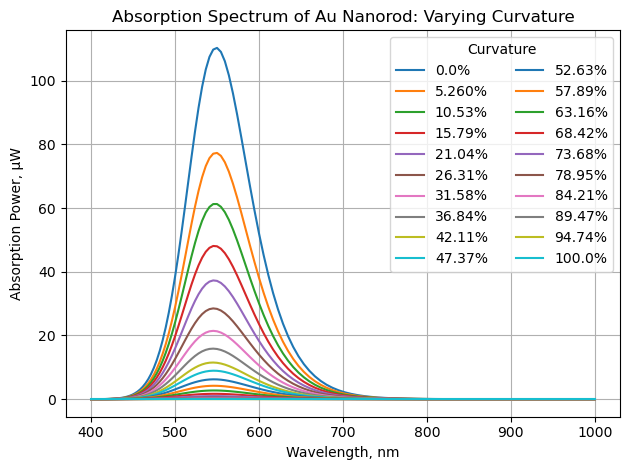

[100. 550.]
[ 94.73684211 550.        ]
[ 89.47368421 550.        ]
[ 84.21052632 545.45454545]
[ 78.94736842 545.45454545]
[ 73.68421053 545.45454545]
[ 68.42105263 545.45454545]
[ 63.15789474 545.45454545]
[ 57.89473684 545.45454545]
[ 52.63157895 545.45454545]
[ 47.36842105 545.45454545]
[ 42.10526316 545.45454545]
[ 36.84210526 545.45454545]
[ 31.57894737 545.45454545]
[ 26.31578947 545.45454545]
[ 21.05263158 545.45454545]
[ 15.78947368 545.45454545]
[ 10.52631579 545.45454545]
[  5.26315789 545.45454545]
[  0.         605.50458716]


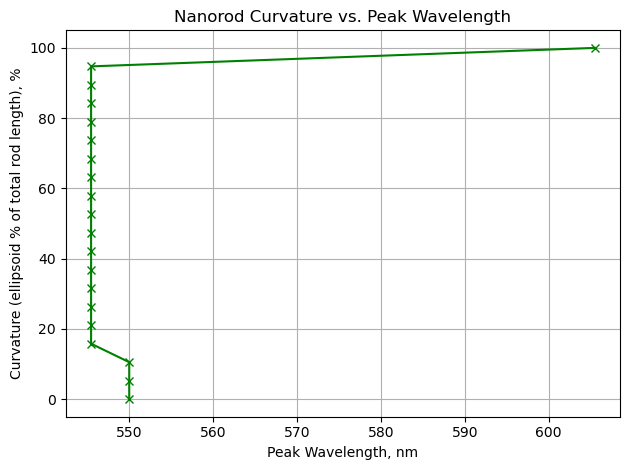

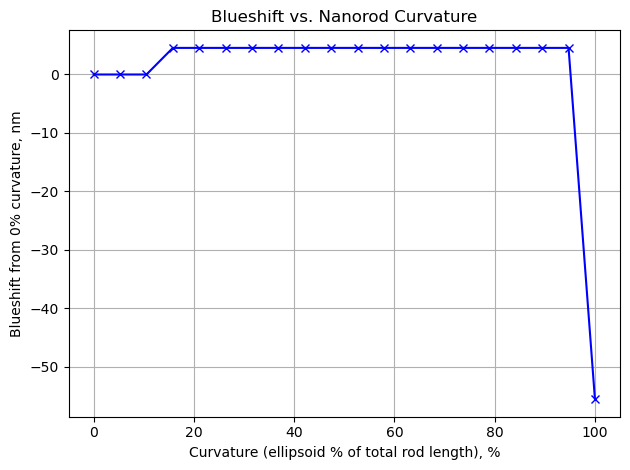

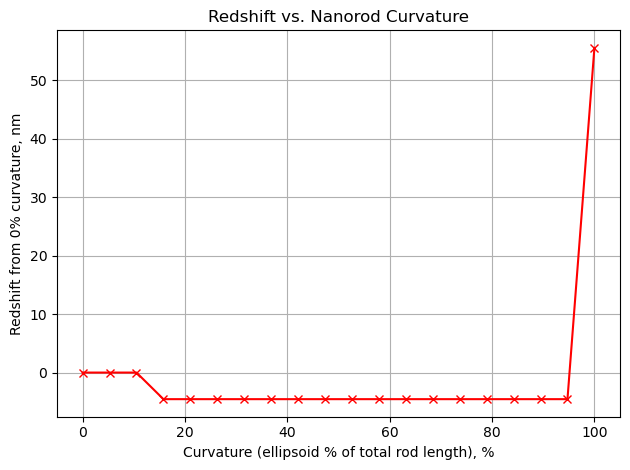

In [4]:
max_wvls = [] #to store the wavelength value where the peak occurs
index = 0

scatt_data = np.asarray(scatt_data)
freq_data = np.asarray(freq_data)    #turn both lists into numpy arrays for easy processing.

#for each row, plot the data, find the max wavelength, and use the percentage value for label.

for run in scatt_data:
    
    scatt_flux = run
    freqs = freq_data[index]
    perc = percentages[index]
    
    plt.plot(1E3/freqs, -1*scatt_flux*1E6, "-", label=f"{str(100-round(float(perc),2))[:5]}%")
    plt.grid(True, which="both", ls="-")
    plt.xlabel("Wavelength, nm")
    plt.ylabel("Absorption Power, μW")
    #plt.yscale("symlog", linthresh=5E-9) #linear threshold says the region about 0 to scale linearly

    plt.legend(loc="upper right", title = "Curvature", ncol=2)
    plt.title("Absorption Spectrum of Au Nanorod: Varying Curvature")
    plt.tight_layout()


    #Frequency position of the peak is the index of the max value in scattered flux data, in frequencies.
    # Doing argmin since the scattering peak is the largest negative value.
    max_wvl = 1E3/freqs[np.argmin(scatt_flux)]
    max_wvls.append([float(perc), max_wvl])

    index += 1 #So the percentage value in the percentages array changes for each row.

plt.savefig(fname="Absorption Spectrum of an Au Nanorod: Varying Curvature",
            dpi=150, 
            bbox_inches="tight")
plt.show()

max_wvls = np.asarray(max_wvls)
for row in max_wvls:
    print(row)


#plot curvature vs. peak position

plt.plot(max_wvls[:,1], 100-max_wvls[:,0], "gx-")
plt.grid(True, which="both", ls="-")
plt.xlabel("Peak Wavelength, nm")
plt.ylabel("Curvature (ellipsoid % of total rod length), %")
plt.title("Nanorod Curvature vs. Peak Wavelength")
plt.tight_layout()
plt.savefig(fname="Nanorod Curvature vs Peak Wavelength",
            dpi=150, 
            bbox_inches="tight")
plt.show()


#Plot of redshift vs. curvature

redshift = max_wvls[:,1]-max_wvls[0,1] #peak position minus 100% cylinder position
curvature = 100-max_wvls[:,0]

plt.plot(curvature, -1*redshift, "bx-")
plt.grid(True, which="both", ls="-")
plt.xlabel("Curvature (ellipsoid % of total rod length), %")
plt.ylabel("Blueshift from 0% curvature, nm")
plt.title("Blueshift vs. Nanorod Curvature")
plt.tight_layout()
plt.savefig(fname="Blueshift vs Nanorod Curvature",
            dpi=150, 
            bbox_inches="tight")
plt.show()

plt.plot(curvature, redshift, "rx-")
plt.grid(True, which="both", ls="-")
plt.xlabel("Curvature (ellipsoid % of total rod length), %")
plt.ylabel("Redshift from 0% curvature, nm")
plt.title("Redshift vs. Nanorod Curvature")
plt.tight_layout()
plt.savefig(fname="Redshift vs Nanorod Curvature",
            dpi=150, 
            bbox_inches="tight")
plt.show()


550.0
550.0
550.0
545.4545454545454
545.4545454545454
545.4545454545454
545.4545454545454
545.4545454545454
545.4545454545454
545.4545454545454
545.4545454545454
545.4545454545454
545.4545454545454
545.4545454545454
545.4545454545454
545.4545454545454
545.4545454545454
545.4545454545454
545.4545454545454
605.5045871559633
1000.0
1000.0
1000.0
1000.0
1000.0
1000.0
1000.0
1000.0
1000.0
1000.0
1000.0
1000.0
1000.0
1000.0
1000.0
1000.0
1000.0
1000.0
1000.0
540.983606557377


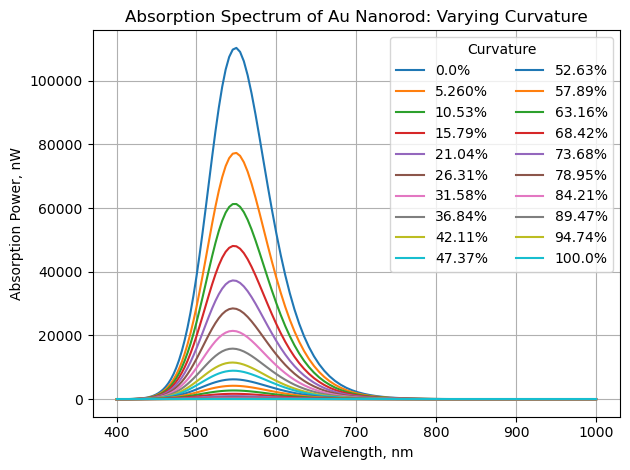

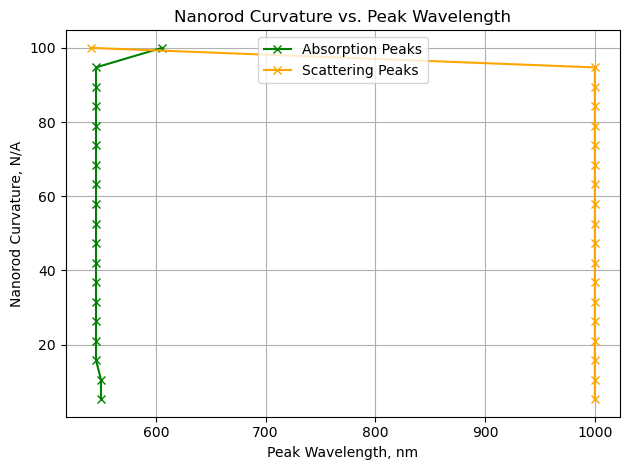

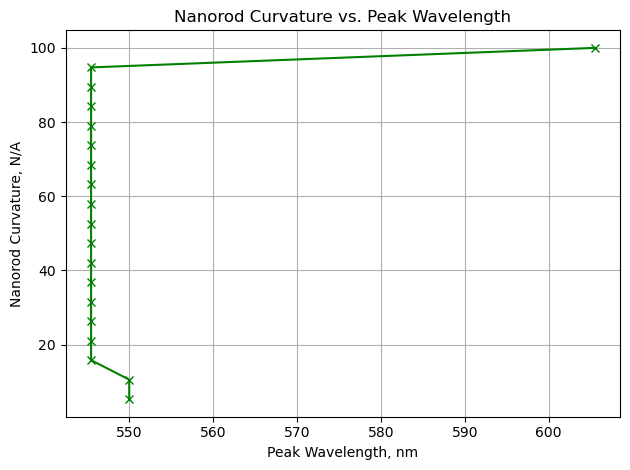

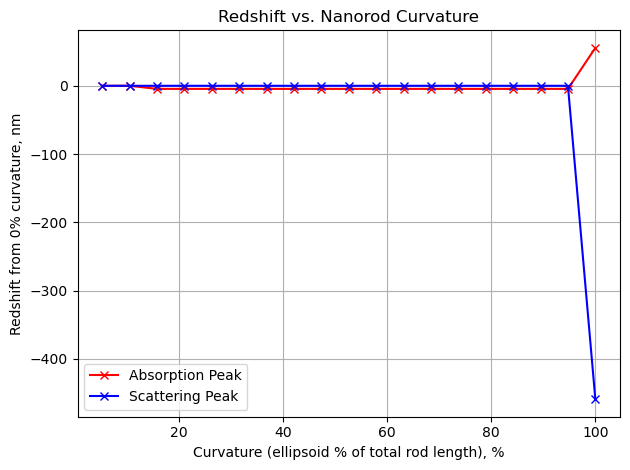

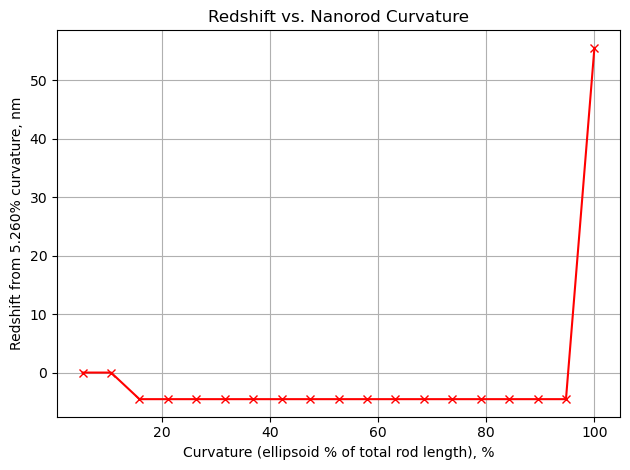

In [5]:
max_wvls_ab = [] #to store the wavelength value where the peak occurs
max_wvls_sc = []
index = 0

scatt_data = np.asarray(scatt_data)
freq_data = np.asarray(freq_data)    #turn both lists into numpy arrays for easy processing.

#for each row, plot the data, find the max wavelength, and use the percentage value for label.

for run in scatt_data:
    
    scatt_flux = run
    freqs = freq_data[index]
    perc = percentages[index]

    plt.plot(1E3/freqs, -1*scatt_flux*1E9, "-", label=f"{str(100-round(float(perc),2))[:5]}%")
    plt.grid(True, which="both", ls="-")
    plt.xlabel("Wavelength, nm")
    plt.ylabel("Absorption Power, nW")
    #plt.yscale("symlog", linthresh=5E-9) #linear threshold says the region about 0 to scale linearly

    plt.legend(loc="upper right", title = "Curvature", ncol=2)
    plt.title("Absorption Spectrum of Au Nanorod: Varying Curvature")
    plt.tight_layout()


    #Frequency position of the peak is the index of the max value in scattered flux data, in frequencies.
    # Doing argmin since the scattering peak is the largest negative value.
    max_wvl_ab = 1E3/freqs[np.argmin(scatt_flux)]
    
    max_wvl_sc = 1E3/freqs[np.argmax(scatt_flux)]
    
    max_wvls_ab.append(max_wvl_ab)
    max_wvls_sc.append(max_wvl_sc)

    index += 1 #So the percentage value in the percentages array changes for each row.

plt.savefig(fname="Absorption Spectrum of Au Nanorod: Varying Curvature",
            dpi=150, 
            bbox_inches="tight")

max_wvls_ab = np.asarray(max_wvls_ab)
max_wvls_sc = np.asarray(max_wvls_sc)

for row in max_wvls_ab:
    print(row)

for row in max_wvls_sc:
    print(row)

#plot curvature vs. peak position

plt.figure()
plt.plot(max_wvls_ab[1:], 100-100*fractions[1:], "gx-", label="Absorption Peaks")
plt.plot(max_wvls_sc[1:], 100-100*fractions[1:], "x-",c="orange", label="Scattering Peaks")
plt.grid(True, which="both", ls="-")
plt.xlabel("Peak Wavelength, nm")
plt.ylabel("Nanorod Curvature, N/A")
plt.title("Nanorod Curvature vs. Peak Wavelength")
plt.tight_layout()
plt.legend(loc="upper center")
plt.savefig(fname="Nanorod Curvature vs Peak Wavelength, both peaks",
            dpi=150, 
            bbox_inches="tight")

plt.figure()
plt.plot(max_wvls_ab[1:], 100-100*fractions[1:], "gx-", label="Absorption Peaks")
plt.grid(True, which="both", ls="-")
plt.xlabel("Peak Wavelength, nm")
plt.ylabel("Nanorod Curvature, N/A")
plt.title("Nanorod Curvature vs. Peak Wavelength")
plt.tight_layout()
plt.savefig(fname="Nanorod Curvature vs Peak Wavelength, one peaks",
            dpi=150, 
            bbox_inches="tight")

curvature = 100-100*fractions

#Plot of redshift vs. Curvature
redshift_ab = max_wvls_ab[:]-max_wvls_ab[1] #peak position minus longest cylinder position
redshift_sc = max_wvls_sc[:]-max_wvls_sc[1]

plt.figure()
plt.plot(curvature[1:], redshift_ab[1:], "rx-", label="Absorption Peak")
plt.plot(curvature[1:], redshift_sc[1:], "bx-", label="Scattering Peak")
plt.grid(True, which="both", ls="-")
plt.xlabel("Curvature (ellipsoid % of total rod length), %")
plt.ylabel("Redshift from 0% curvature, nm")
plt.title("Redshift vs. Nanorod Curvature")
plt.tight_layout()
plt.legend(loc="lower left")
plt.savefig(fname="Redshift vs Aspect-Ratio, both peaks",
            dpi=150, 
            bbox_inches="tight")

plt.figure()
plt.plot(curvature[1:], redshift_ab[1:], "rx-", label="Absorption Peak")
plt.grid(True, which="both", ls="-")
plt.xlabel("Curvature (ellipsoid % of total rod length), %")
plt.ylabel("Redshift from 5.260% curvature, nm")
plt.title("Redshift vs. Nanorod Curvature")
plt.tight_layout()
plt.savefig(fname="Redshift vs Aspect-Ratio, one peaks",
            dpi=150, 
            bbox_inches="tight")



-----------
Initializing structure...
Padding y to even number of grid points.
Padding z to even number of grid points.
Halving computational cell along direction y
Halving computational cell along direction z
time for choose_chunkdivision = 0.00342703 s
Working in 3D dimensions.
Computational cell is 0.039875 x 0.039875 x 0.039875 with resolution 6896.55
     ellipsoid, center = (0,0.0127,0)
          size (0.0145,0,0.0145)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2,2,2)
     ellipsoid, center = (0,-0.0127,0)
          size (0.0145,0,0.0145)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2,2,2)
     cylinder, center = (0,0,0)
          radius 0.00725, height 0.0254, axis (0, 1, 0)
          dielectric constant epsilon diagonal = (2,2,2)
time for set_epsilon = 8.42366 s
time for set_conductivity = 0.161289 s
time for set_conductivity = 0.182124 s
time for set_conductivity = 0.217225 s
--------

run 0 finished at t = 1.0000650000000002 (13794 timesteps)
-----------
Initializing structure...
Padding y to even number of grid points.
Padding z to even number of grid points.
Halving computational cell along direction y
Halving computational cell along direction z
time for choose_chunkdivision = 0.00321484 s
Working in 3D dimensions.
Computational cell is 0.039875 x 0.039875 x 0.039875 with resolution 6896.55
     ellipsoid, center = (0,0.0112889,0)
          size (0.0145,0.00282222,0.0145)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2,2,2)
     ellipsoid, center = (0,-0.0112889,0)
          size (0.0145,0.00282222,0.0145)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2,2,2)
     cylinder, center = (0,0,0)
          radius 0.00725, height 0.0225778, axis (0, 1, 0)
          dielectric constant epsilon diagonal = (2,2,2)
time for set_epsilon = 12.9642 s
time for set_conductivity = 0.141522 s


-----------
Initializing structure...
Padding y to even number of grid points.
Padding z to even number of grid points.
Halving computational cell along direction y
Halving computational cell along direction z
time for choose_chunkdivision = 0.00272489 s
Working in 3D dimensions.
Computational cell is 0.039875 x 0.039875 x 0.039875 with resolution 6896.55
     ellipsoid, center = (0,0.00987778,0)
          size (0.0145,0.00564444,0.0145)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2,2,2)
     ellipsoid, center = (0,-0.00987778,0)
          size (0.0145,0.00564444,0.0145)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2,2,2)
     cylinder, center = (0,0,0)
          radius 0.00725, height 0.0197556, axis (0, 1, 0)
          dielectric constant epsilon diagonal = (2,2,2)
time for set_epsilon = 15.0098 s
time for set_conductivity = 0.142288 s
time for set_conductivity = 0.148075 s
time for set_condu

-----------
Initializing structure...
Padding y to even number of grid points.
Padding z to even number of grid points.
Halving computational cell along direction y
Halving computational cell along direction z
time for choose_chunkdivision = 0.00250292 s
Working in 3D dimensions.
Computational cell is 0.039875 x 0.039875 x 0.039875 with resolution 6896.55
     ellipsoid, center = (0,0.00846667,0)
          size (0.0145,0.00846667,0.0145)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2,2,2)
     ellipsoid, center = (0,-0.00846667,0)
          size (0.0145,0.00846667,0.0145)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2,2,2)
     cylinder, center = (0,0,0)
          radius 0.00725, height 0.0169333, axis (0, 1, 0)
          dielectric constant epsilon diagonal = (2,2,2)
time for set_epsilon = 16.0016 s
time for set_conductivity = 0.148514 s
time for set_conductivity = 0.144565 s
time for set_condu

-----------
Initializing structure...
Padding y to even number of grid points.
Padding z to even number of grid points.
Halving computational cell along direction y
Halving computational cell along direction z
time for choose_chunkdivision = 0.00377393 s
Working in 3D dimensions.
Computational cell is 0.039875 x 0.039875 x 0.039875 with resolution 6896.55
     ellipsoid, center = (0,0.00705556,0)
          size (0.0145,0.0112889,0.0145)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2,2,2)
     ellipsoid, center = (0,-0.00705556,0)
          size (0.0145,0.0112889,0.0145)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2,2,2)
     cylinder, center = (0,0,0)
          radius 0.00725, height 0.0141111, axis (0, 1, 0)
          dielectric constant epsilon diagonal = (2,2,2)
time for set_epsilon = 17.9918 s
time for set_conductivity = 0.191138 s
time for set_conductivity = 0.198054 s
time for set_conduct

run 0 finished at t = 1.0000650000000002 (13794 timesteps)
-----------
Initializing structure...
Padding y to even number of grid points.
Padding z to even number of grid points.
Halving computational cell along direction y
Halving computational cell along direction z
time for choose_chunkdivision = 0.00276995 s
Working in 3D dimensions.
Computational cell is 0.039875 x 0.039875 x 0.039875 with resolution 6896.55
     ellipsoid, center = (0,0.00564444,0)
          size (0.0145,0.0141111,0.0145)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2,2,2)
     ellipsoid, center = (0,-0.00564444,0)
          size (0.0145,0.0141111,0.0145)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2,2,2)
     cylinder, center = (0,0,0)
          radius 0.00725, height 0.0112889, axis (0, 1, 0)
          dielectric constant epsilon diagonal = (2,2,2)
time for set_epsilon = 25.5144 s
time for set_conductivity = 0.162724 s


-----------
Initializing structure...
Padding y to even number of grid points.
Padding z to even number of grid points.
Halving computational cell along direction y
Halving computational cell along direction z
time for choose_chunkdivision = 0.0044868 s
Working in 3D dimensions.
Computational cell is 0.039875 x 0.039875 x 0.039875 with resolution 6896.55
     ellipsoid, center = (0,0.00423333,0)
          size (0.0145,0.0169333,0.0145)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2,2,2)
     ellipsoid, center = (0,-0.00423333,0)
          size (0.0145,0.0169333,0.0145)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2,2,2)
     cylinder, center = (0,0,0)
          radius 0.00725, height 0.00846667, axis (0, 1, 0)
          dielectric constant epsilon diagonal = (2,2,2)
time for set_epsilon = 22.2764 s
time for set_conductivity = 0.173556 s
time for set_conductivity = 0.175601 s
time for set_conduct

-----------
Initializing structure...
Padding y to even number of grid points.
Padding z to even number of grid points.
Halving computational cell along direction y
Halving computational cell along direction z
time for choose_chunkdivision = 0.00408888 s
Working in 3D dimensions.
Computational cell is 0.039875 x 0.039875 x 0.039875 with resolution 6896.55
     ellipsoid, center = (0,0.00282222,0)
          size (0.0145,0.0197556,0.0145)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2,2,2)
     ellipsoid, center = (0,-0.00282222,0)
          size (0.0145,0.0197556,0.0145)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2,2,2)
     cylinder, center = (0,0,0)
          radius 0.00725, height 0.00564444, axis (0, 1, 0)
          dielectric constant epsilon diagonal = (2,2,2)
time for set_epsilon = 23.1947 s
time for set_conductivity = 0.189897 s
time for set_conductivity = 0.161815 s
time for set_conduc

-----------
Initializing structure...
Padding y to even number of grid points.
Padding z to even number of grid points.
Halving computational cell along direction y
Halving computational cell along direction z
time for choose_chunkdivision = 0.00349092 s
Working in 3D dimensions.
Computational cell is 0.039875 x 0.039875 x 0.039875 with resolution 6896.55
     ellipsoid, center = (0,0.00141111,0)
          size (0.0145,0.0225778,0.0145)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2,2,2)
     ellipsoid, center = (0,-0.00141111,0)
          size (0.0145,0.0225778,0.0145)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2,2,2)
     cylinder, center = (0,0,0)
          radius 0.00725, height 0.00282222, axis (0, 1, 0)
          dielectric constant epsilon diagonal = (2,2,2)
time for set_epsilon = 20.089 s
time for set_conductivity = 0.184808 s
time for set_conductivity = 0.178334 s
time for set_conduct

-----------
Initializing structure...
Padding y to even number of grid points.
Padding z to even number of grid points.
Halving computational cell along direction y
Halving computational cell along direction z
time for choose_chunkdivision = 0.00360608 s
Working in 3D dimensions.
Computational cell is 0.039875 x 0.039875 x 0.039875 with resolution 6896.55
     ellipsoid, center = (0,0,0)
          size (0.0145,0.0254,0.0145)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2,2,2)
     ellipsoid, center = (0,-0,0)
          size (0.0145,0.0254,0.0145)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2,2,2)
     cylinder, center = (0,0,0)
          radius 0.00725, height 0, axis (0, 1, 0)
          dielectric constant epsilon diagonal = (2,2,2)
subpixel-averaging is 57.41% done, 2.99229 s remaining
time for set_epsilon = 26.5635 s
time for set_conductivity = 0.162971 s
time for set_conductivity = 0.170629

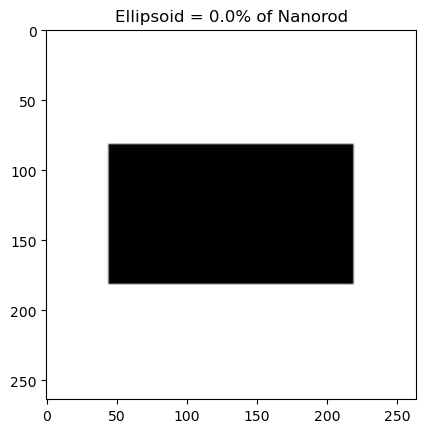

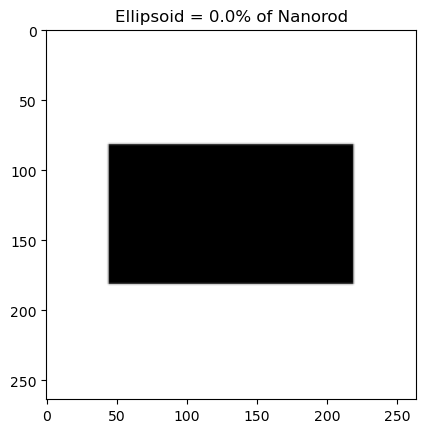

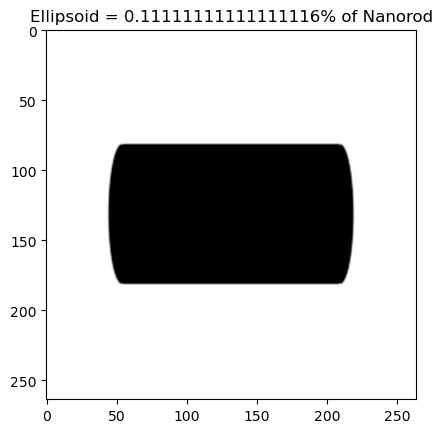

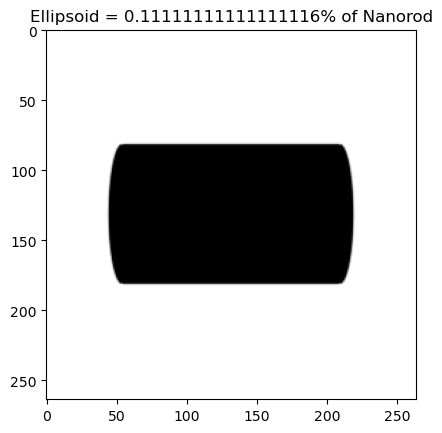

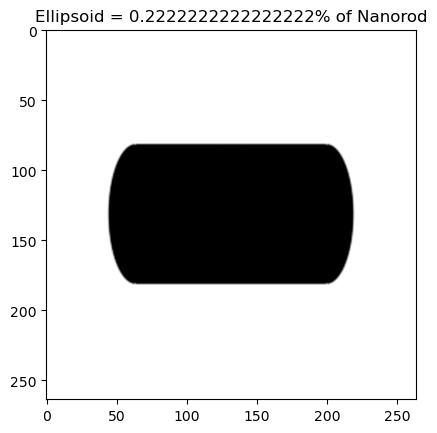

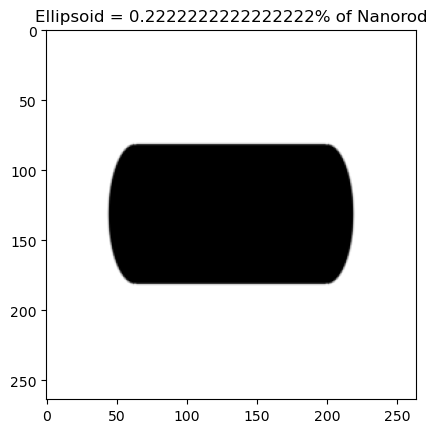

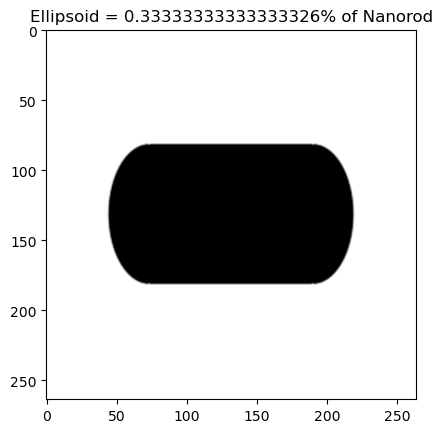

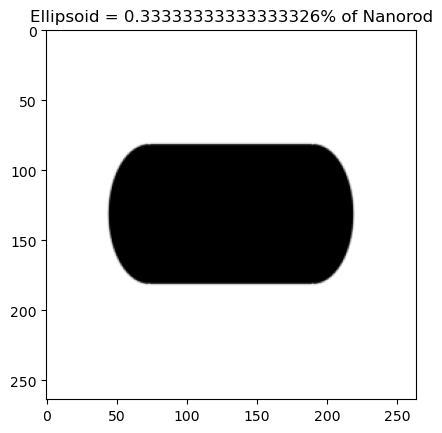

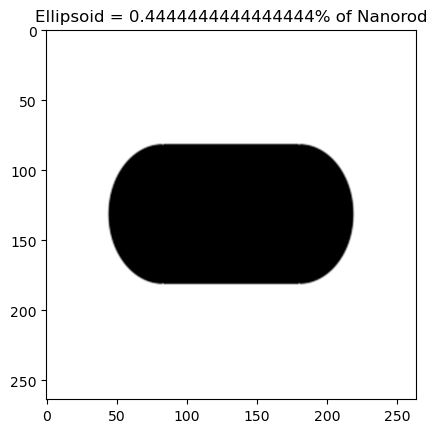

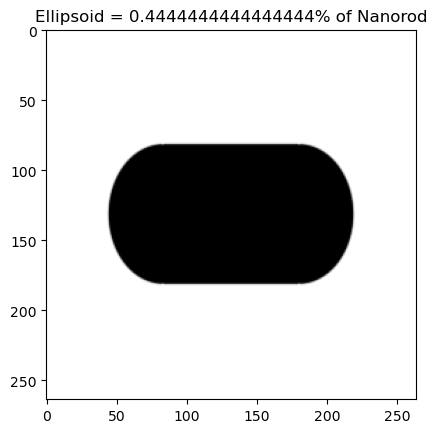

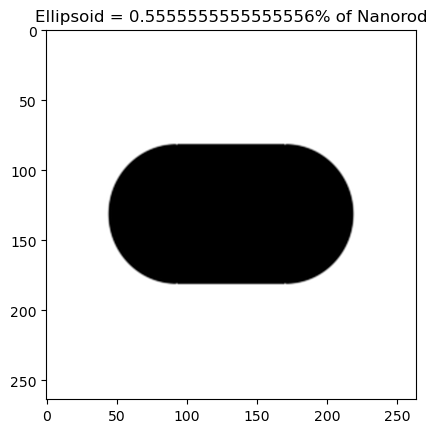

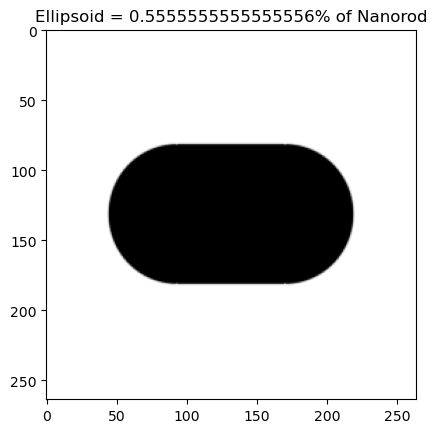

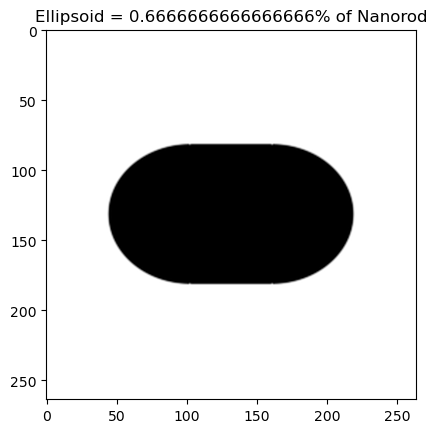

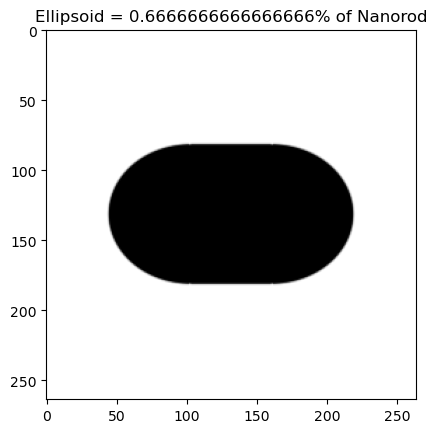

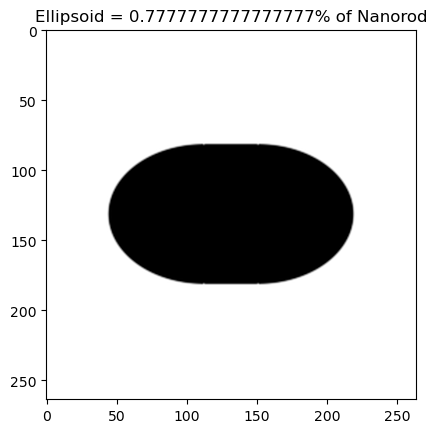

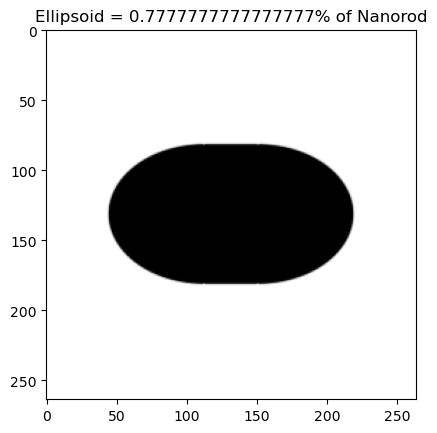

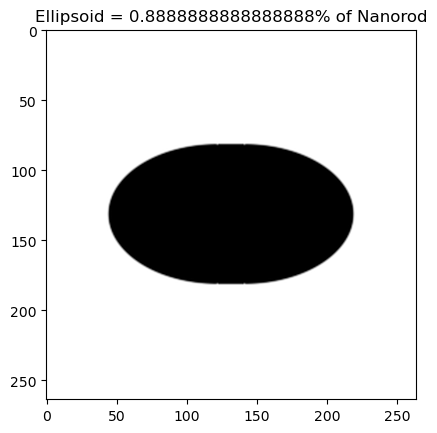

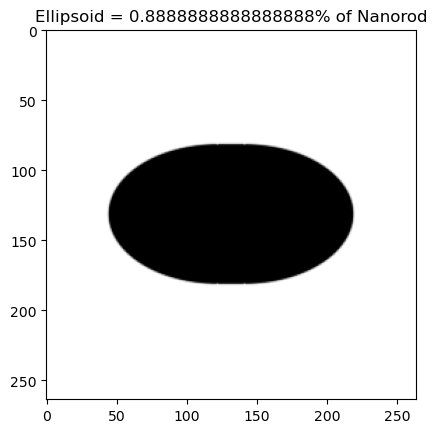

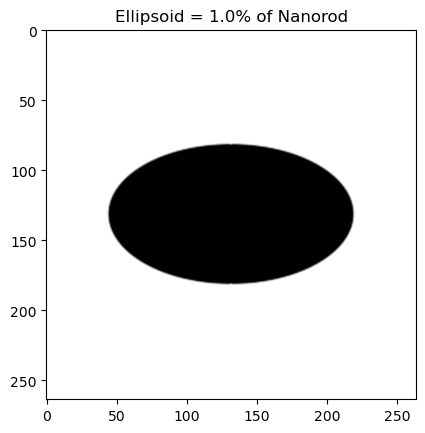

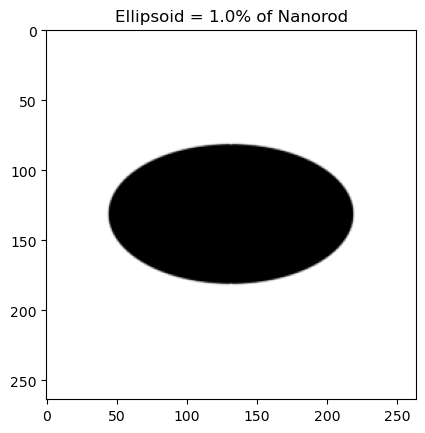

In [10]:
# Visualising nanorods at different curvatures.

import meep as mp
import numpy as np
import matplotlib.pyplot as plt

def visualise_nanorod(frac):

    r = 7.25E-3  # radius of cylinder
    l = 25.40E-3 # length of rod

    l_c = frac*l # length of cylinder
    
    l_e = 0.5*(l-l_c) # length of half ellipsoid
    
    #default medium is water
    default_material = mp.Medium(index=1.3325)
    
    wvl = 535E-3
    frq = 1 / wvl
    
    resolution = 50/r
    
    dpml = 2*r
    pml_layers = [mp.PML(thickness=dpml)]
    
    symmetries = [mp.Mirror(mp.Y), mp.Mirror(mp.Z, phase=-1)]
    
    s = l + dpml 
    cell_size = mp.Vector3(s, s, s)
    
    #random dielectric constant.
    #dielectric constant used is 2+2i. Must convert 2i into conductivity since MEEP can't process the complex.
    epsilon_Au = 2
    D_Conductivity_Au = 2*np.pi*0.42*2/3.4
    
    
    
    ellip_1 = mp.Ellipsoid(material=mp.Medium(epsilon=epsilon_Au, D_conductivity=D_Conductivity_Au),
                           size = mp.Vector3(2*r, 2*l_e, 2*r),
                           center=mp.Vector3(0, 0.5*l_c, 0))
    
    ellip_2 = mp.Ellipsoid(material=mp.Medium(epsilon=epsilon_Au, D_conductivity=D_Conductivity_Au),
                           size = mp.Vector3(2*r, 2*l_e, 2*r),
                           center=mp.Vector3(0, -0.5*l_c, 0))
    
    #axis says the orentation of the cylinder
    cylinder = mp.Cylinder(material=mp.Medium(epsilon=epsilon_Au, D_conductivity=D_Conductivity_Au),
                           radius=r,
                           height=l_c,
                           center=mp.Vector3(),
                           axis=mp.Vector3(0, 1, 0))
    
    
    
    # appending a shape will just replace any overlap with existing shapes with itself.
    
    geometry = [ellip_1, ellip_2, cylinder]
    
    #geometry.append(ellip_2)
    #geometry.append(sub_box_2)
    #geometry.append(cylinder)
    
    
    
    
    sim = mp.Simulation(
        resolution=resolution,
        cell_size=cell_size,
        boundary_layers=pml_layers,
        k_point=mp.Vector3(),
        symmetries=symmetries,
        geometry=geometry,
    )
    
    
    sim.run(until=1) # /fs
    
    #grab data once run is finished i.e. what the system looks like at 200fs:
    d = 1.5*l
    
    eps_data_x = sim.get_array(center=mp.Vector3(), size=mp.Vector3(0, d, d), component=mp.Dielectric)
    eps_data_y = sim.get_array(center=mp.Vector3(), size=mp.Vector3(d, 0, d), component=mp.Dielectric)
    eps_data_z = sim.get_array(center=mp.Vector3(), size=mp.Vector3(d, d, 0), component=mp.Dielectric)
    
    plt.figure()
    plt.imshow(eps_data_x.transpose(),interpolation='spline36', cmap='binary')
    plt.title(f"Ellipsoid = {1-frac}% of Nanorod")
    
    plt.figure()
    plt.imshow(eps_data_x.transpose(), cmap='binary')
    plt.title(f"Ellipsoid = {1-frac}% of Nanorod")


fractions = np.linspace(1,0,10)

for frac in fractions:
    visualise_nanorod(frac)
    